In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg

%matplotlib inline

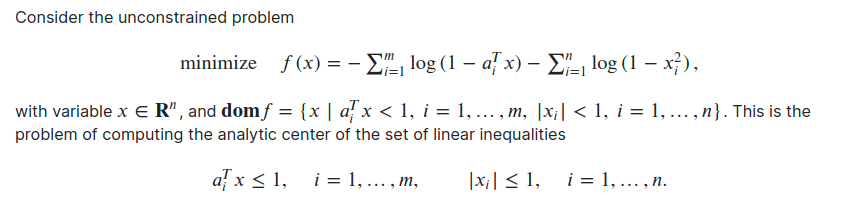

## Gradient and Hessian formulation

$\nabla f(x) = A^T (\frac{1}{1 - Ax})
+ 2 (\frac{x}{1 - x^2}) $

----
$\nabla^2 f(x) = ? $

---
(I):  
$g_1(x) = \frac{1}{x} \implies D g_1(x) = -diag(x^{-2})$

$g_2(x) = 1 - Ax \implies Dg_2(x) = -A \quad \in R^{m \times n}$

$D(g_1(g_2(x))) = Dg_1(g_2(x)) Dg_2(x) 
= diag((1 - Ax)^{-2}) A \quad \in R^{m \times n}$
 
$D[A^T (\frac{1}{1 - Ax})] = A^T diag((1 - Ax)^{-2}) A \quad \in R^{n \times n}$

---
(II)  
$g_3(x) = \frac{x}{1-x^2} = diag(\frac{(1-x^2) - x(-2x)}{(1-x^2)^2}) = 
diag(\frac{(1 + x^2)}{(1-x^2)^2})
$


$(D[2 (\frac{x}{1 - x^2})] = 
2 diag(\frac{(1 + x^2)}{(1-x^2)^2}) \quad \in R^{n \times n}
$

---
With I and II:   
$\nabla^2f(x) = D[ \nabla f(x) ] = 
A^T diag((1 - Ax)^{-2}) A +
2 diag(\frac{(1 + x^2)}{(1-x^2)^2}) \quad \in R^{n \times n}
$

## Problem instances

In [2]:
class Instance:
    msg_out_domain = 'out of domain'
    def __init__(self, A):
        self.A = A
        self.do_ravel = False
    
    @classmethod
    def generate(cls, m = 200, n = 100):
        A = np.random.randn(m,n)
        return Instance(A)
    
    def __str__(self):
        s = f"Instance ({self.A.shape[0]}x{self.A.shape[1]})"
        return s
    
    def __repr__(self):
        return self.__str__()
    
    def preproc(self, x):
        u = 1 - self.A @ x
        z = 1 - x*x
        if (u <= 0).any() or (z <= 0).any():
            return 0,0,False
        u = u.reshape((-1,1))
        z = z.reshape((-1,1))
        return u,z,True
        
    def f(self, x):
        u,z,ok = self.preproc(x)
        if(not ok): return np.inf
        u = np.log(u)
        z = np.log(z)
        ret = -(u.sum() + z.sum())
        return ret
        
    def f_g(self, x):
        u,z,ok = self.preproc(x)
        if(not ok): 
            raise(Exception(self.msg_out_domain))
        A = self.A
        u = 1/u
        assert u.shape[0] == A.shape[0] and u.shape[1] == 1
        u = A.T @ u
        z = 2/z
        z = z * x.reshape((-1,1))
        assert u.shape == z.shape
        ret = u + z
        if(self.do_ravel):
            ret = ret.ravel()
        
        return ret
    
    def f_g2(self, x):
        u,z,ok = self.preproc(x)
        if(not ok): 
            raise(Exception(self.msg_out_domain))
        step = 1e-5
        n = len(x)
        ret = np.zeros((n,1))
        for i in range(n):
            x1 = x.copy()
            x2 = x.copy()
            x1[i] += step
            x2[i] -= step
            ret[i,0] = (I.f(x1) - I.f(x2))/(2*step)
        if self.do_ravel:
            return ret.ravel()
        else:
            return ret
        
    def hess(self, x):
        u,z,ok = self.preproc(x)
        if(not ok): 
            raise(Exception(self.msg_out_domain))
        n = len(x); A = self.A
        u = u**-2
        u = A.T @ np.diag(u.ravel()) @ A
        assert u.shape == (n,n)
        z = 2 * (1+x**2).ravel() * (z**-2).ravel()
        z = np.diag(z)
        assert z.shape == (n,n)
        return u + z
    

## Test gradient and hessian

In [3]:
n = 10; m = 20
tol = 1e-6

# Test gradient
I = Instance.generate(m = m, n = n)
x = np.random.uniform(0,0.01,n)
assert (np.abs(I.f_g(x) - I.f_g2(x)) < tol).all()

# Test Hessian
delta = 1e-6
for i in range(n):
    aux = np.zeros_like(x)
    aux[i] = 1
    hi = (I.f_g(x + aux*delta) - I.f_g(x - aux*delta))/(2*delta)
    assert (hi - I.hess(x)[:,[i]] < tol).all()
    

## Statistics collector and plot

In [4]:
class Stats:
    def __init__(self):
        self.data = []
        
    def new_exp(self, method):
        assert method in {'newton', 'gradient'}
        D = {
            'it' : [],
            'fx' : [],
            'g_norm' : [],
            'lambda2' : [],
            'step_size' : [],
            'method' : method,
            }
        self.data.append(D)
    
    def new_it(self, it, fx, step_size, g_norm = None, lambda2 = None):
        self.data[-1]['it'].append(it)
        self.data[-1]['fx'].append(fx)
        self.data[-1]['step_size'].append(step_size)
        if g_norm is not None:
            self.data[-1]['g_norm'].append(float(g_norm))
        if lambda2 is not None:
            self.data[-1]['lambda2'].append(float(lambda2))
            
            
    def plot_exp(self, exp_id = 0, fig = None, ax = None):
        if ax is None:
            fig, ax = plt.subplots(2,2, figsize = (20,20))
        
        data = self.data[exp_id]
        data['fx - optimal'] = np.array(data['fx']) - data['fx'][-1]
        
        eps_log = 1e-10
        
        def info(i,j):
            if i == 0 and j == 0:
                return "fx", data['fx']
            if i == 0 and j == 1: 
                return "log(fx - optimal)", np.log10(data['fx - optimal'] + eps_log)
            if i == 1 and j == 0: 
                return "log_step_size", np.log10(data['step_size'][:-1])
            if i == 1 and j == 1:
                name = "lambda2" if data["method"] == "newton" else "g_norm"
                return 'log'+name, np.log10(data[name])
            
        for i in range(2):
            for j in range(2):
                name , y = info(i,j)
                ax[i,j].plot(data['it'][:len(y)], y)
                ax[i,j].set_xlabel('it')
                ax[i,j].set_ylabel(name)
        
        return fig, ax

## Backtracking line search

In [5]:
def bt_linesearch(f, x, g, v, alpha, beta, log = True):
    """
    search for t s.t
    f(x + tv) <= f(x) + alpha * t * g^T * v
    
    Returns
    -------
    new point: x + tv
    """
    assert alpha > 0 and alpha < 0.5
    assert beta > 0 and beta < 1
    t = 1.0
    f0 = f(x)
    dv = (g.T @ v)
    log_per = 10
    max_it = 100
    if log:
        print(f'begining ls: f0 {f0} dv {dv}')
        
    assert dv < 0, 'descent direction'
    it = 0
    while f(x + t * v) > f0 + alpha * t * dv:
        t *= beta
        if(log and log_per % 10 == 0):
            print(f'it: {it} t: {t} f: {f(x + t * v)}')
        it += 1
        if(it >= max_it):
            raise(Exception('no convergence in backtracking ls'))
    
    if log:
        print(f'it: {it} t: {t} f0: {f0} f: {f(x + t * v)}')
        
    assert f(x + t*v) <= f0
    return t

## Gradient method

In [6]:
def gradient_method(x0, f, f_g, alpha = 0.2, beta = 0.7, g_tol = 1e-5, 
                   log = True, config = {}, stats : Stats  = None):
    # config
    max_it = config.get('max_it', 10**5)
    log_per = config.get('log_per' , max_it//10)
    # initial condition
    x = x0
    it = 0
    while it < max_it:
        it += 1
        g = f_g(x)
        g_norm = np.linalg.norm(g, 2)
        fx = f(x)    
        if g_norm < g_tol:
            # stoping criterion
            t = None
        else:
            # direction
            v = -g
            # line search
            t = bt_linesearch(f, x, g, v, alpha, beta, log)
        
        # statistics
        if stats is not None:
            stats.new_it(it, fx, t, g_norm = g_norm)
            
        if t is None:
            break
            
        # update
        x = x + t*v
        
        # log
        if((it-1) % log_per == 0 and log):
            print('='*100)
            print(f'it {it} f(old) {fx} f(new) {f(x)}')
            print('g_norm',g_norm)
            print('x_new:', x[:10].T, '...')
            print('='*100)
        
    if g_norm >= g_tol:
        raise(Exception(f'No convergence. g_norm = {g_norm}'))
        
    return x, f(x), g, it

## Newton method

In [7]:
def newton_method(x0, f, f_g, f_hess, alpha = 0.2, beta = 0.7, 
                  lambda2_tol = 1e-6, log = True, config = {}, stats = None):
    # config parametrs
    max_it = config.get('max_it', 10**3)
    log_per = config.get('log_per' , 1)
    # initial conditions
    x = x0
    convergence = False
    it = 0
    while it < max_it:
        it += 1
        g = f_g(x)
        u = linalg.solve(f_hess(x), g, assume_a = 'pos', check_finite = True)
        fx = f(x)
        # newton decrement
        lambda2 = g.T @ u
        
        if lambda2/2 <= lambda2_tol:
            # stop criterion
            convergence = True
            t = None
        else:
            # direction
            v = -u
            # line search
            t = bt_linesearch(f, x, g, v, alpha, beta, log)
            
        # stats
        if stats is not None:
            stats.new_it(it, fx, t, lambda2 = lambda2)
        
        # stop criterion flag    
        if t is None:
            break
            
        # update
        x = x + t*v
        
        # log
        if((it-1) % log_per == 0 and log):
            print('='*100)
            print(f'it {it} f(old) {fx} f(new) {f(x)}')
            print('lambda2:',lambda2)
            print('x_new:', x[:10].T, '...')
            print('='*100)

    if not convergence:
        raise(Exception(f'No convergence. lambda2 = {lambda2}'))
        
    return x, f(x), g, lambda2, it

## Generating Instances

In [8]:
np.random.seed(42)
I_list = [I.generate() for i in range(10)]

## Gradient method plots

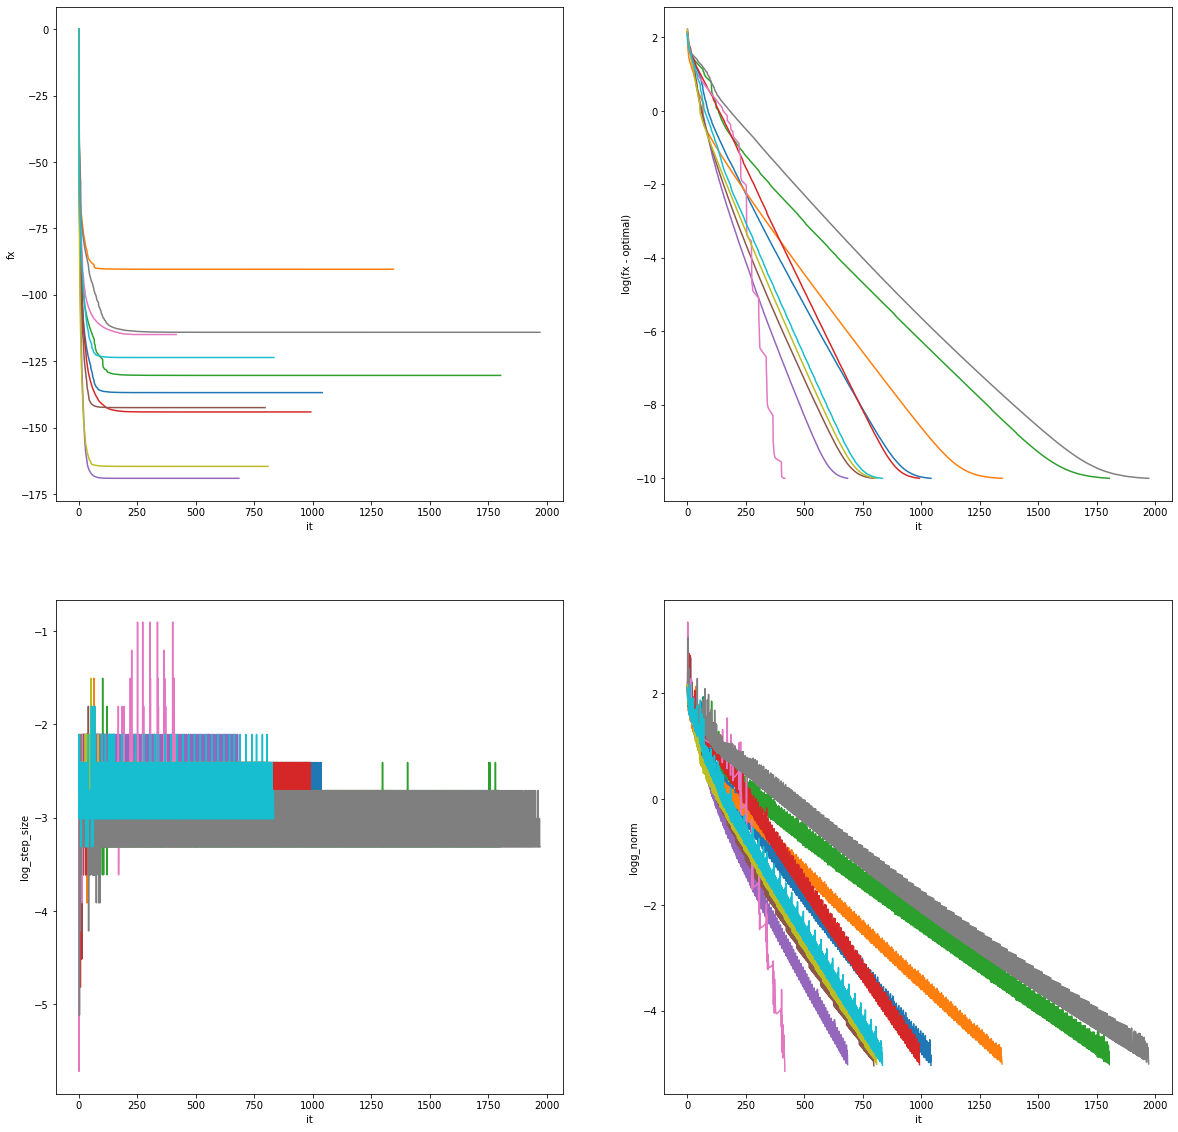

In [9]:
stats = Stats()
fig, ax = None, None

for i,I in enumerate(I_list):
    x0 = np.zeros((I.A.shape[1], 1))
    stats.new_exp('gradient')
    
    x, fx, g, n_it = gradient_method(x0, I.f, I.f_g, 
                                alpha = 0.2,
                                beta = 0.5,
                                log = False, 
                                config = {'max_it' : 10**4, 'log_per' : 10},
                               stats = stats);
    
    fig, ax = stats.plot_exp(i, fig = fig, ax = ax)
    
plt.show()

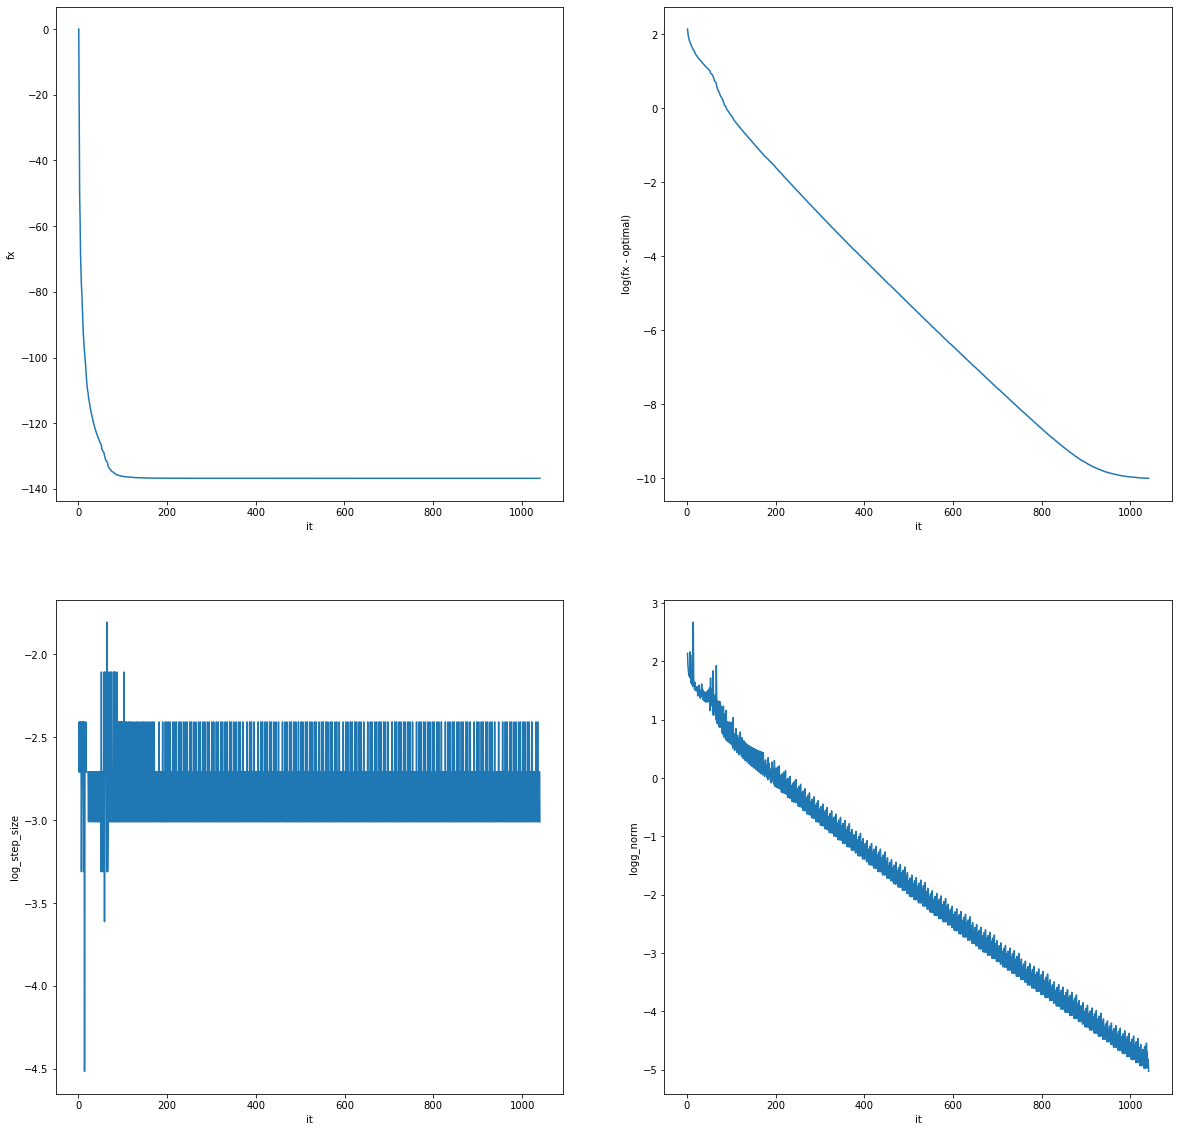

In [10]:
stats.plot_exp(exp_id = 0)
plt.show();

## Newton plots

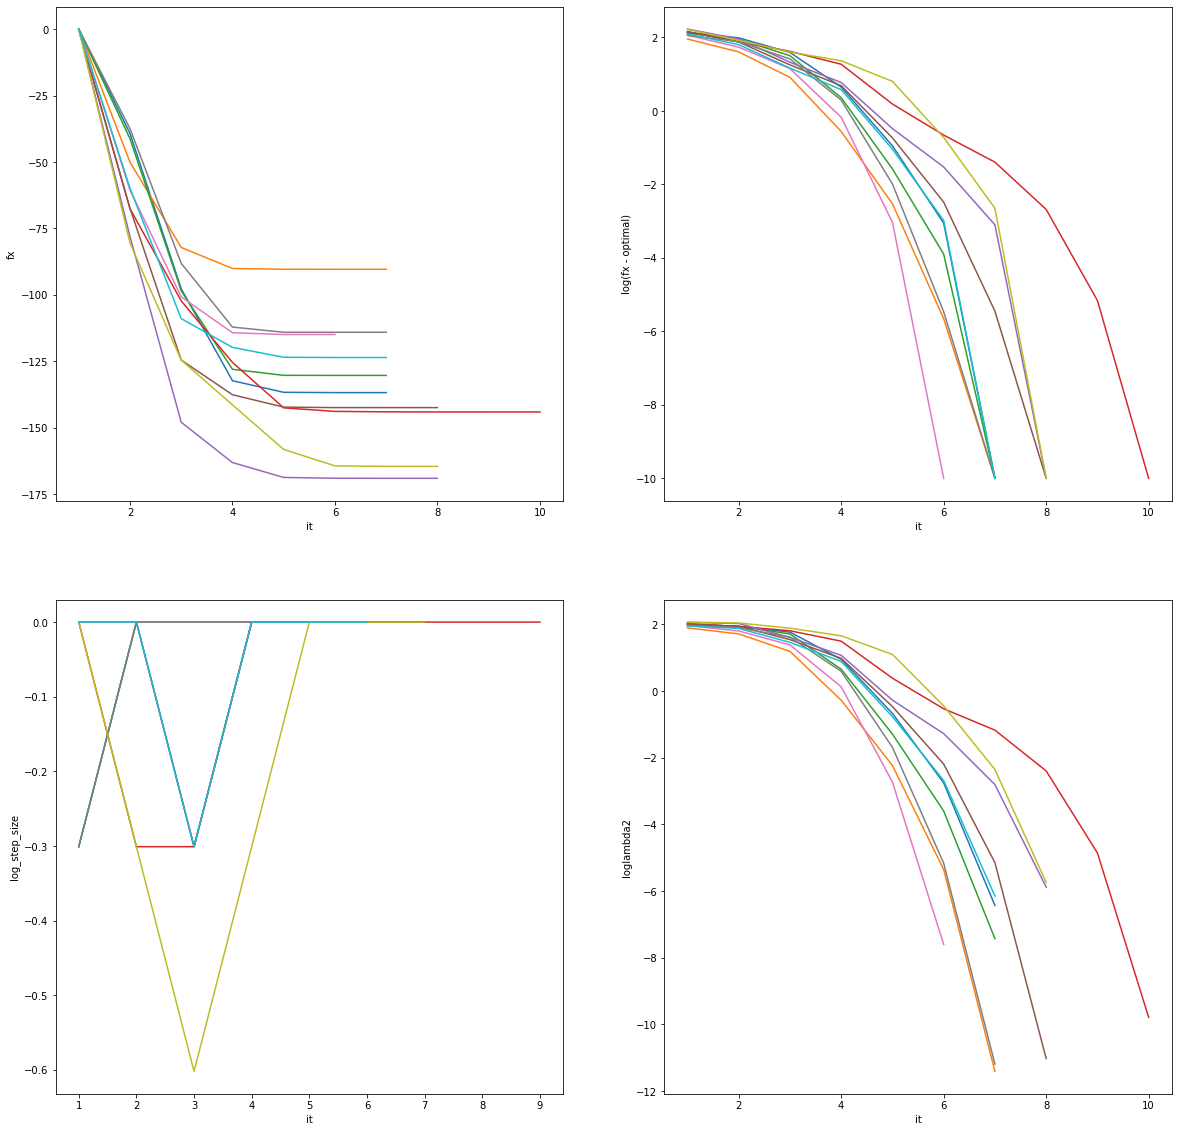

In [11]:
stats = Stats()
fig, ax = None, None

for i,I in enumerate(I_list):
    x0 = np.zeros((I.A.shape[1], 1))
    stats.new_exp('newton')
    
    x, fx, g, lambda2, n_it = newton_method(x0, I.f, I.f_g, I.hess, 
                                      alpha = 0.2,
                                      beta = 0.5, 
                                      log = False, 
                                      config = {'max_it' : 100, 'log_per' : 1},
                                      stats = stats)
    
    fig, ax = stats.plot_exp(i, fig = fig, ax = ax)
    
plt.show()

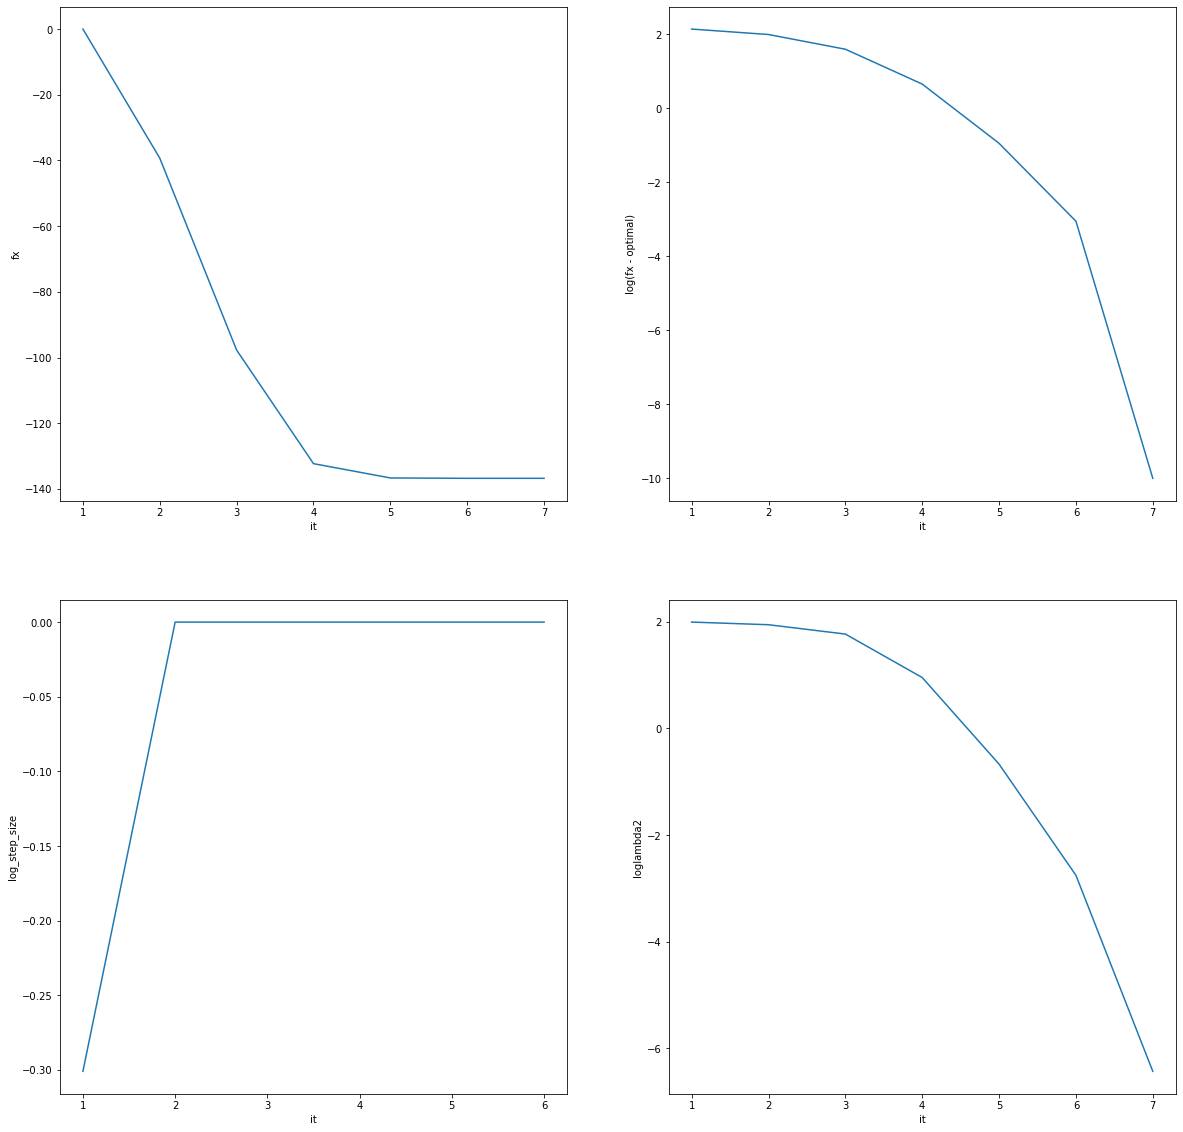

In [12]:
stats.plot_exp(exp_id = 0);

## Changing problem size and line search parameters

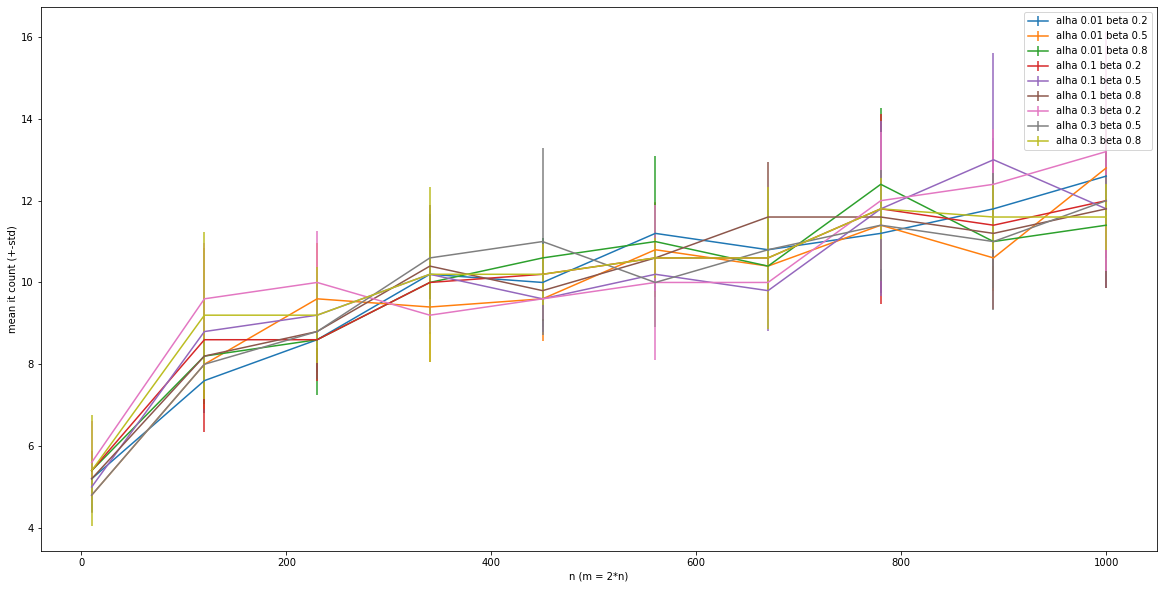

In [13]:

fig, ax = plt.subplots(1, figsize = (20,10))

for i,alpha in enumerate([0.01, 0.1, 0.3]):
    for j,beta in enumerate([0.2, 0.5, 0.8]):
        mean_it = []
        std_it = []
        sizes = []
        for n in np.linspace(10,1000,10):
            n = int(n)
            m = 2*n
            its = []
            x0 = np.zeros((n, 1))
            for _ in range(5):
                I = Instance.generate(n=n,m=m)
                x, fx, g, lambda2, n_it = newton_method(x0, I.f, I.f_g, I.hess, 
                                                  alpha = 0.2,
                                                  beta = 0.5, 
                                                  log = False, 
                                                  config = {'max_it' : 100, 'log_per' : 1},
                                                  stats = None)
                its.append(n_it)

            mean_it.append(np.mean(its))
            std_it.append(np.std(its))
            sizes.append(n)
        
        ax.errorbar(sizes, mean_it, std_it, label = f"alha {alpha} beta {beta}")
        ax.set_xlabel("n (m = 2*n)")
        ax.set_ylabel("mean it count (+-std)")
plt.legend()
plt.show()

# Testing other solvers

In [14]:
from scipy.optimize import minimize

res = minimize(I.f, x0, 
               # method='nelder-mead',
               method='powell',
               options={'xatol': 1e-6, 'disp': True})

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: OptimizeWarning: Unknown solver options: xatol
  
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [15]:
I.do_ravel = True

res = minimize(I.f, x0.ravel(), method='BFGS', jac = None,
               options={'disp': True})

I.do_ravel = False

/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numd

KeyboardInterrupt: 